In [37]:
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import pipeline2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Histogram of Gradients

The code for extracting HOG features from images is in the method `pipeline.extract_features`. This method can combine up to 3 different types of features. The first set of features are the pixels of a scaled down image. The theory is a scaled down image should contain enough information from the original image to characterize it. The second set of features is the histogram of pixel intensities. The final set of features is the histogram of gradients in the image.

After experimentation on the final video output of detected vehicles, I settled on the RGB color space and the following HOG parameters: (INCLUDE PARAMETERS HERE). My experimentation showed that the features from a scaled down image and a histogram of pixel intensities weren't of much use. With just the HOG features and the mentioned parameters, my code was able to produce a video output with the most consistent bounding boxes around vehicles. (SHOW IMAGE OF HOG features)

The images below show the example car and non-car images along with a visualization of their HOG features.

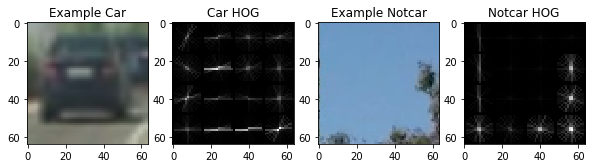

In [40]:
import cv2
import glob
import matplotlib.image as mpimg
import numpy as np
from skimage.feature import hog
from global_settings import *
# Read in our vehicles and non-vehicles
cars = [image for image in glob.glob('dataset/vehicles/*/*.png')]
notcars = [image for image in glob.glob('dataset/non-vehicles/*/*.png')]

cars = cars[:1]
notcars = notcars[:1]

car_img = mpimg.imread(cars[0])
gray_car = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)

features, car_hog_image = pipeline2.get_hog_features(gray_car, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

notcar_img = mpimg.imread(notcars[0])
gray_notcar = cv2.cvtColor(notcar_img, cv2.COLOR_RGB2GRAY)

features, notcar_hog_image = pipeline2.get_hog_features(gray_notcar, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(141)
plt.imshow(car_img, cmap='gray')
plt.title('Example Car')
plt.subplot(142)
plt.imshow(car_hog_image, cmap='gray')
plt.title('Car HOG')
plt.subplot(143)
plt.imshow(notcar_img, cmap='gray')
plt.title('Example Notcar')
plt.subplot(144)
plt.imshow(notcar_hog_image, cmap='gray')
plt.title('Notcar HOG')

# Training a classifier
With the ability to extract features from an image, the next step is to train on these extracted features. Using Udacity's provided dataset of car and non-car images, I trained a support vector machine (SVM) classifier. The code is in the method `pipeline.train`. This method is given two sets of images, cars and non-cars. From these sets of images, HOG features are extracted out. Because we know which images are cars and which ones aren't, we can then associate all the car HOG features with the car label (1) and the non-car HOG features with non-car label (0). This allows the SVM to use supervised learning to associate a car's features to the car label and likewise for non-cars.

Furthermore, to allow the classifier to converge and thus train more quickly, the features are scaled to unit variance.

# Sliding Window Search and Heatmaps
I implemented a sliding window search algorithm in `pipeline.search_windows`. The algorithm simply scans chunks of the an image from left to right and top to bottom. While scanning the chunks of images, the features from those chunks are extracted and then classified with the trained SVM. Those that return a label of '1' are considered cars. Thus, this is how the bounding boxes for the cars are founded.

The chunks of images overlap at 75% because this creates a lot of windows around a vehicle. A dense region of windows is highly likely a vehicle, which is why this percentage was chosen. Regions without lots of windows are likely to be false positives, which I can then reject as non-cars. Below are images which windows drawn around regions likely to be vehicles.

Once the regions of an image are analyzed, the next step is to mark each pixel within a window so that a heatmap can be generated. The result is a map of pixels that are within windows. From there, we can draw a bounding box around the marked pixels to determine the final bounding box around what is hopefully a vehicle. You can see the heatmaps and bounding boxes around those areas below.

In [ ]:
pipeline2.run_windows()

Reading training data and training classifier from scratch


100%|██████████| 8968/8968 [00:29<00:00, 299.41it/s]


Using: 30 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 3240


# Tracking Heatmaps in a Video
As mentioned above, regions with many windows are likely to be vehicles. In a video that consists of a continual stream of frames, I keep track of the previous `N` windows, where `N` is a configurable number. Then I generate a cumulative heatmap for that frame based on windows from the current and past frames. If heatmap contains pixels above a configurable threshold, then we know more than likely we've found a vehicle.

# Suggestions for Improvement
To improve this pipeline, the support vector machine classifier could be swapped out with a convolutional neural network classifier. This classifier would likely have a higher classification accuracy. With a higher accuracy, I could reduce the overlap percentage in the sliding window search, which would also speed up the pipeline since there would be fewer windows to search. Furthermore, it'd reduce the number of false positives.

In [35]:
# TODO: clean up code
# TODO: refactor HotWindows
# TODO: create video and submit project